<a href="https://colab.research.google.com/github/js-iMore/Analitica_tareas/blob/master/Housing_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade tensorflow

In [0]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.1.0'

In [0]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

#Acceso a los archivos desde Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#
file_id1 = '1pXnhCBJ-zS5n-rwA-Bn3o5_leYx2npEz' #Base de datos
csv_path = drive.CreateFile({'id': file_id1})
csv_path.GetContentFile('housing.csv') 

file_id2 = '1rvdtwtfawd2mI_dRqYhLx6G2DvcJYuw4'
funcionesH = drive.CreateFile({'id': file_id2})
funcionesH.GetContentFile('funciones_housing.py') #Funciones

from funciones_housing import dummy_transformer, pre_exploratorio, save_fig


%matplotlib inline

img_path = ''
Xdata = pd.read_csv('housing.csv') #Pandas para sacar estadisticos simples

In [0]:
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
Xtrain , Xval = train_test_split(Xtrain, test_size=0.3)
col_sal = "median_house_value"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
yval = Xval[col_sal]
Xtrain.drop(columns=col_sal,inplace=True) #Inplace para actualizar el cambio
Xtest.drop(columns=col_sal,inplace=True)
Xval.drop(columns=col_sal,inplace=True)

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

impt = SimpleImputer(strategy = "median")
ytrain = impt.fit_transform(pd.DataFrame(ytrain)) 
ytest = impt.transform(pd.DataFrame(ytest))  #Los datos pandas, Dataframe 
yval = impt.transform(pd.DataFrame(yval)) 

preproceso = dummy_transformer()
norm = StandardScaler()

Xtrain = preproceso.fit_transform(Xtrain)
Xval = preproceso.transform(Xval)

Xtrain = norm.fit_transform(Xtrain)
Xval = norm.transform(Xval)

Xtest = preproceso.transform(Xtest)
Xtest = norm.transform(Xtest)

Ahora sigue la creación del modelo multicapa

In [0]:
keras.backend.clear_session() #Reinicio de variables
np.random.seed(42)  #Guardando posición de los pesos
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(9,)))
model.add(keras.layers.Dense(600, activation="linear"))
model.add(keras.layers.Dense(300, activation="tanh"))
model.add(keras.layers.Dense(100, activation="sigmoid"))
model.add(keras.layers.Dense(1)) #Son 9 neuronas basados en las categorias de la base de datos Housing

In [0]:
model.layers

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 600)               6000      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 216,501
Trainable params: 216,501
Non-trainable params: 0
_________________________________________________________________


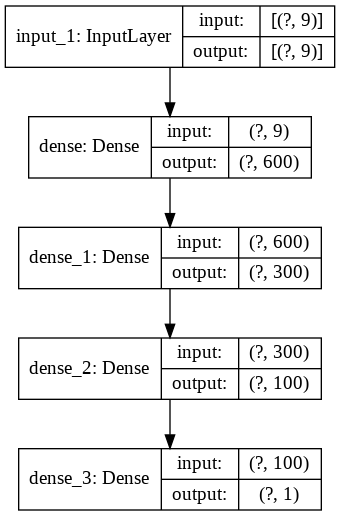

In [0]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [0]:
model.compile(loss="mse", 
              optimizer="sgd",
              metrics=["mae"])

#funcion derivable y continua -> Loss


In [0]:
history = model.fit(Xtrain, ytrain, epochs=30, batch_size=32 ,
                    validation_data=(Xval, yval))

#Batch_size toma grupos de datos(lotes) de train 

Train on 10113 samples, validate on 4335 samples
Epoch 1/30
10113/10113 [==============================] - 2s 187us/sample - loss: 13553986969.5797 - mae: 91070.3047 - val_loss: 94348307785.5225 - val_mae: 246392.6562
Epoch 2/30
10113/10113 [==============================] - 2s 154us/sample - loss: 13479651897.2602 - mae: 90725.6953 - val_loss: 27515944266.9398 - val_mae: 142860.0469
Epoch 3/30
10113/10113 [==============================] - 2s 160us/sample - loss: 13344751601.3432 - mae: 90811.9844 - val_loss: 13196623569.4062 - val_mae: 90650.5469
Epoch 4/30
10113/10113 [==============================] - 2s 158us/sample - loss: 13202684755.1563 - mae: 90094.0156 - val_loss: 40389525467.1502 - val_mae: 164393.6719
Epoch 5/30
10113/10113 [==============================] - 2s 159us/sample - loss: 13252716759.9280 - mae: 90265.5859 - val_loss: 13042859471.9299 - val_mae: 92798.6484
Epoch 6/30
10113/10113 [==============================] - 2s 148us/sample - loss: 13223318717.4180 - mae: 90

In [0]:
model.evaluate(Xtest, ytest)

6192/6192 [==============================] - 0s 61us/sample - loss: 13248848057.2196 - mae: 88584.9609


[13248848057.219639, 88584.96]

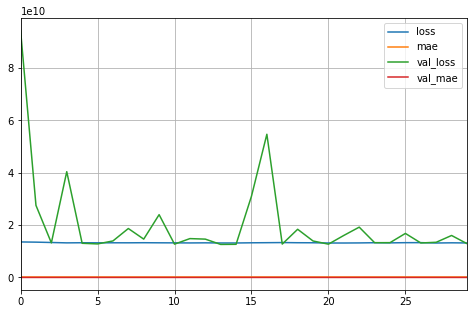

In [0]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

plt.show()

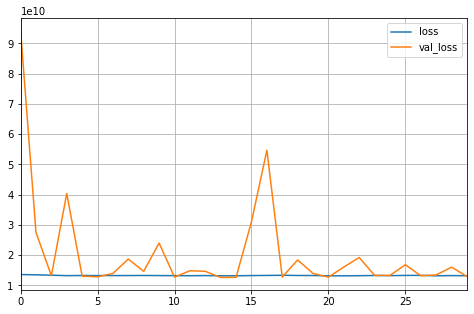

In [0]:
his = pd.DataFrame(history.history)
columns = his.columns

his[[columns[0], columns[2]]].plot(figsize=(8,5))
plt.grid(True)

plt.show()

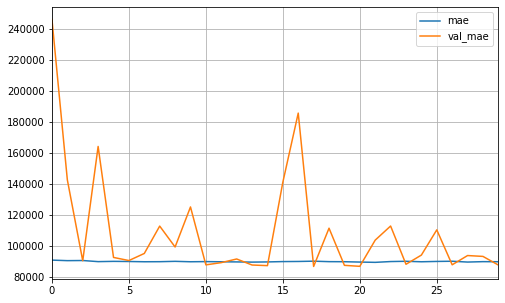

In [0]:
his[[columns[1], columns[3]]].plot(figsize=(8,5))
plt.grid(True)

plt.show()

Entrenamiento con API funcional

In [0]:
input_ = keras.layers.Input(shape=Xtrain.shape[1:])
hidden1 = keras.layers.Dense(30,activation='tanh')(input_)
hidden2 = keras.layers.Dense(30,activation='tanh')(hidden1)

concat = keras.laters.Concatenate()([input_,hidden2])
output = leras.layers.Dense(1)(concat)
model_fun = keras.Model(inputs=[input_], outputs=[output])

In [0]:
input_ = keras.layers.Input(shape=Xtrain.shape[1:])
hidden1 = keras.layers.Dense(30,activation='tanh')(input_)
hidden2 = keras.layers.Dense(10,activation='tanh')(hidden1)
#Ahora al tener dos salidas:
concat = keras.layers.Concatenate()([input_,hidden2])
output_A = keras.layers.Dense(1)(concat)
output_B = keras.layers.Dense(1, activation = 'sigmoid')(concat)
model_2out = keras.Model(inputs=[input_], outputs=[output_A, output_B])

In [0]:
model_2out.compile(loss=[keras.losses.mse, keras.losses.binary_crossentropy],
                   optimizer="sgd", loss_weights = [0.7,0.3],
                   metrics = [keras.losses.mae, "accuracy"])

In [0]:
ytrainB = ytrain>ytrain.mean()
yvalidB = yval>yval.mean()

In [0]:
history = model_2out.fit(Xtrain, [ytrain,ytrainB],
                         epochs =30,
                         validation_data= ([Xval], [yval, yvalidB]))

Train on 10113 samples, validate on 4335 samples
Epoch 1/30
10113/10113 [==============================] - 1s 135us/sample - loss: 5553613976.9975 - dense_11_loss: 7994529280.0000 - dense_12_loss: 0.9304 - dense_11_mean_absolute_error: 64567.2656 - dense_11_accuracy: 0.0000e+00 - dense_12_mean_absolute_error: 0.5525 - dense_12_accuracy: 0.3690 - val_loss: 4625465015.2157 - val_dense_11_loss: 6589808640.0000 - val_dense_12_loss: 0.8206 - val_dense_11_mean_absolute_error: 56825.5312 - val_dense_11_accuracy: 0.0000e+00 - val_dense_12_mean_absolute_error: 0.5223 - val_dense_12_accuracy: 0.4496
Epoch 2/30
10113/10113 [==============================] - 1s 67us/sample - loss: 3825763545.8012 - dense_11_loss: 5629124608.0000 - dense_12_loss: 0.7472 - dense_11_mean_absolute_error: 54507.8750 - dense_11_accuracy: 0.0000e+00 - dense_12_mean_absolute_error: 0.4955 - dense_12_accuracy: 0.5444 - val_loss: 4011288582.7322 - val_dense_11_loss: 5722563584.0000 - val_dense_12_loss: 0.6994 - val_dense_11

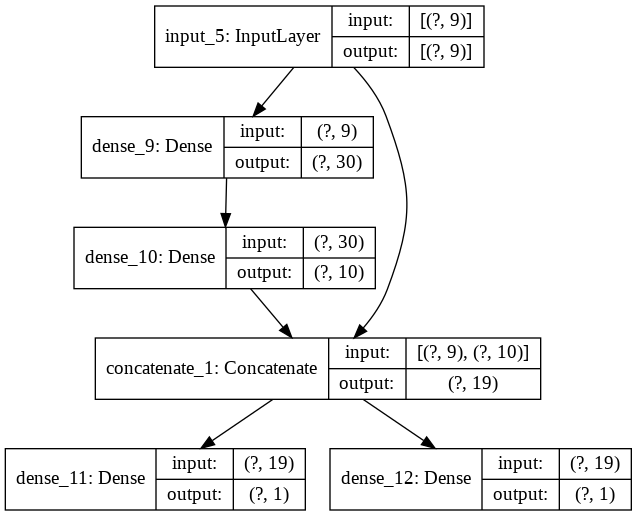

In [0]:
keras.utils.plot_model(model_2out, "my_mnist_model2.png", show_shapes=True)